In [1]:
import time
#import cupy as cu
import numpy as np
import readDICOM as dcm
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
#from os import chdir, getcwd
import os
workspace = os.getcwd()
def calTime(end, start):
    elapsed_time = end - start
    q, mod = divmod(elapsed_time, 60)
    if q < 60:
        print('Calculation time: %d minutes %d seconds.' % (q, mod))
    else:
        q2, mod2 = divmod(q, 60)
        print('Calculation time: %d h %d minutes.' % (q2, mod2))

In [2]:
#ベクトルの更新
#計算位置の初期化ができていません
#ボクセルが変わると位置が更新できるようにする
#
def vectorUpdate(v,G,f="float32"):
    #それぞれの関数を変数に入れて文字数を少なくする
    add = np.add
    mul = np.multiply
    sub = np.subtract
    sqr = np.sqrt
    squ = np.square
    neg = np.negative
    
    #Zが１かそれ以外で分離
    #v1は|µz|<=0.99999
    #v2は|µz|>0.99999
    
    th = 0.99999
    v1_index = np.where(np.abs(v[2])<=th)[0].tolist()
    v2_index = np.where(np.abs(v[2])>th)[0].tolist()
    
    v1 = v[:,v1_index]
    v1size = v1[0].size
    
    v2 = v[2][np.abs(v[2])>th]
    v2size = v2.size
    
    #cos(theta)とsin(theta)と求める
    g = 0.9
    G1 = (1+g**2)/(2*g)
    G2 = sqr(2*g)/(1+g)
    G3 = sqr(8*g**3)/(1-g**2)
    cosTh = G1-np.reciprocal(squ(G2+G3*np.random.rand(v1size).astype(f)))
    #air_index = np.where(G[v1_index]==0)[0].tolist()
    #cosTh[air_index] = 2*np.random.rand(len(air_index)).astype(f)-1
    sinTh = sqr(1-squ(cosTh))
    
    #cos(fai)とsin(fai)と求める
    Fi = 2*np.pi*np.random.rand(v1size).astype(f)
    cosFi = np.cos(Fi)
    sinFi = np.sin(Fi)
    
    #v1ベクトルの更新
    A = np.reciprocal(sqr(1-squ(v1[2])))
    B = mul(A,v1)
    B[2] = neg(np.reciprocal(B[2]))
    v[:,v1_index] = add(mul(v1,cosTh),
                        add(mul(mul(sinTh,cosFi),mul(v1[2],B)),
                            mul(mul(A,sinTh),
                                mul(sinFi,np.array([neg(v1[1]),v1[0],np.zeros(v1size)],dtype=f)))))
    
    #v2ベクトルの更新
    cosTh = G1-np.reciprocal(squ(G2+G3*np.random.rand(v2size).astype(f)))
    #air_index = np.where(G[v2_index]==0)[0].tolist()
    #cosTh[air_index] = 2*np.random.rand(len(air_index)).astype(f)-1
    sinTh = sqr(1-squ(cosTh))
    Fi = 2*np.pi*np.random.rand(v2size).astype(f)
    v[:,v2_index] = np.array([mul(sinTh,np.cos(Fi)),
                  mul(sinTh,np.sin(Fi)),
                  mul(np.sign(v2),cosTh)],dtype=f)
    return v

def positionUpdate(p,v,L):
    return np.add(p,np.multiply(v,L))


#境界におけるベクトル,位置,番地の更新
def updateOnBoundary(v,p,add,A,B,f="float32"):
    ## 境界面上にある光子の更新はこの関数で定義されます。
    ## ここでは、透過判別や反射、屈折の計算を行います。
    
    #境界を超える前後の屈折率を取得  
    ni,nt = getNiNt(add,v,A)
    #境界前後で屈折率が変化する場合のindex
    pb_index = np.where(ni!=nt)[0]

    if pb_index != []: 
        #透過判別
        #入射角の計算
        ai = np.abs(A[:,pb_index]*v[:,pb_index])
        ai = np.arccos(ai[ai!=0])#Aから算出される0を排除して1次元配列にする
        #全反射するときのインデックスを取得
        sub_index = np.where(ai>=np.arcsin(nt[pb_index]/ni[pb_index]))[0].tolist()
        #屈折角の計算
        ##(ai,at)=(0,0)の時は透過させ方向ベクトルは変化させない
        at = np.arcsin(np.multiply(np.divide(ni[pb_index],nt[pb_index]),np.sin(ai)))
        Ra = np.random.rand(ai.size)-0.5*(np.add(np.divide(np.sin(ai-at),np.sin(ai+at))**2,
                                                 np.divide(np.tan(ai-at),np.tan(ai+at))**2))
        #全反射はRaを強制的に0以下にし反射させる
        Ra[sub_index] = -1
        
        #透過と反射のindexを取得
        vl_index = pb_index[np.where(Ra<=0)[0].tolist()].tolist()#反射
        sub_index = np.where(Ra>0)[0].tolist()#Raに対する透過のindex
        vt_index = pb_index[sub_index].tolist()#全体ベクトルvに対する透過のindex
        
        #反射するときのベクトルを更新
        v[:,vl_index] = np.multiply(v[:,vl_index],
                                   np.subtract(B[:,vl_index],A[:,vl_index]))
        
        #透過するときのベクトルを更新
        if vt_index !=[]:
            v[:,vt_index] = np.multiply(np.divide(ni[vt_index],nt[vt_index]),
                                        np.add(np.multiply(v[:,vt_index],B[:,vt_index]),
                                               np.multiply(A[:,vt_index],np.multiply(np.sign(v[:,vt_index]),
                                                                                     np.cos(at[sub_index])))))
            
        #境界を超えた時の位置更新,番地の更新
        pt_index = np.delete(np.arange(ni.size),vl_index)
        p[:,pt_index] = np.multiply(p[:,pt_index],B[:,pt_index]-A[:,pt_index])
        add[:,pt_index] = nextAddress(add[:,pt_index],v[:,pt_index],A[:,pt_index])
    
    else:#boxcelの状態変化が全くなかった場合
        p = np.multiply(p,B-A)
        add = nextAddress(add,v,A)
    return v,p,add

def russianRoulette(w,f="float32"):
    ## 確率的に光子を生き返らせます。
    
    m = 10
    ra = np.random.rand(w.size).astype(f)
    index = np.where(ra>(1/m))[0].tolist()
    w[index] = 0
    index = np.where(ra<=(1/m))[0].tolist()
    w[index] = w[index]*m
    return w
    
def endPoint(v,p,add,w):
    ## 計算を終了する条件を記述した関数です
    ## 以下の条件になった光子を消去します。
    ## 試料から出たとき、photon waightが既定値を下り、
    ## ロシアンルーレットでお亡くなりになられた光子は消去されます。
    ## なお、計測面から出た光子はresultの中に保存されます。
    
    #計測面以外から出たとき
    c = np.array(ConstPixelDims)-2
    del_index = np.where((add[0]>c[0])|(add[1]>c[1])|(add[2]>c[2])|(add[0]<0)|(add[1]<0))[0].tolist()
    v = np.delete(v, del_index, axis = 1)
    p = np.delete(p, del_index, axis = 1)
    add = np.delete(add, del_index, axis = 1)
    w = np.delete(w,del_index)
    
    #photn waight が0.0001以下
    del_index = np.where(w<=0.0001)[0].tolist()
    if del_index != []:
        w[del_index] = russianRoulette(w[del_index])
        del_index = np.where(w==0)[0].tolist()
        v = np.delete(v, del_index, axis = 1)
        p = np.delete(p, del_index, axis = 1)
        add = np.delete(add, del_index, axis = 1)
        w = np.delete(w, del_index)
        
    #計測面から光子がでたとき
    del_index = np.where(add[2]<0)[0].tolist()
    result = ([v[:,del_index],p[:,del_index],add[:,del_index],w[del_index]])
    v = np.delete(v, del_index, axis = 1)
    p = np.delete(p, del_index, axis = 1)
    add = np.delete(add, del_index, axis = 1)
    w = np.delete(w, del_index)
    return v,p,add,w,result
    
#屈折率ni,ntの取得
def getNiNt(add,v,A):
    ni = dataArrayTissue(add,"n")
    add = nextAddress(add,v,A)
    nt = dataArrayTissue(add,"n")
    return ni,nt

#透過後の番地を取得
def nextAddress(add,v,A):
    return np.add(add,np.multiply(np.sign(v),A)).astype("int16")

#散乱係数の取得
def getScatteringCoeff(Brightness):# /cm 換算
    Brightness[Brightness>0] = (0.016*Brightness[Brightness>0]*256-119.75) #### 確認が必要 #####
    Brightness[Brightness==0] = 0.0001 #空気のパラメーター
    Brightness[Brightness==-1] = 191   #緻密骨のパラメーター #### 確認が必要 #####
    Brightness[Brightness==-2] = 188   #皮膚のパラメーター
    return Brightness

#吸収係数の取得
def getAbsorptionCoeff(Brightness): # /cm 換算
    Brightness[Brightness>0]=0.11   #海綿骨のパラメーター
    Brightness[Brightness==0]=0.0001 #空気のパラメーター
    Brightness[Brightness==-1] = 0.11 #緻密骨のパラメーター
    Brightness[Brightness==-2] = 0.37 #皮膚のパラメーター
    return Brightness

#異方性係数の取得
def anisotropyCoeff(Brightness):
    Brightness[Brightness>0]=0.93
    Brightness[Brightness==0]=0.0001 #空気のパラメーター
    Brightness[Brightness==-1] = 0.93 #緻密骨のパラメーター
    Brightness[Brightness==-2] = 0.93 #皮膚のパラメーター    
    return Brightness

#光学特性の取得
def dataArrayTissue(add,mode):
    ## 屈折率とそれ以外の光学特性を取得する2つのモードがあり、
    ## 'n'もしくは'u'の文字列をmodeの引数にわたすことでモードの切り替えを行います。
    ## 屈折率はこの関数内で定義され、それ以外それぞれ独自の関数で定義します。
    
    #rowデータにおける番地を取得
    Brightness = Tissue[add.tolist()]
    #骨である番地のインデックスを取得
    #porevalue = 0
    #poreindex = np.where(Brightness==porevalue)
    data = np.ones(Brightness.size)
    if mode == "n":
        boneindex = np.where((Brightness>0) | (Brightness==-2) | (Brightness==-1))
        data[boneindex] = 1.5
    elif mode == "u":
        data = np.empty((3,Brightness.size))
        data[0] = getAbsorptionCoeff(Brightness.astype("float16"))
        data[1] = getScatteringCoeff(Brightness.astype("float16"))
        data[2] = anisotropyCoeff(Brightness.astype("float16"))
    return data
                                
#光子の１ステップにおけるエネルギーの損失を計算
def wUpdate(w,ua,us,diff):
    return np.multiply(w,(1-diff/(us/ua+1)))

#光子の移動距離
def stepLength(size,ua,us,f="float32"):
    return np.divide(-np.log(np.random.rand(size)).astype(f), ua+us)*10

#光子位置の更新（境界条件付き）
def updater(p,v,add,w,l=1,f="float32"):
    ## 光子の位置並びにベクトルを更新します。
    ## 基本的にはWangのMCMLと同様の方法で更新を行いますが、voxcel計算また、
    ## Numpyの配列を用いて計算させるため、ブロードキャストを用いた場合分けを行います。
    
    #境界までの距離Sを算出
    S = np.divide(np.subtract(l/2,np.multiply(p,np.sign(v))),np.abs(v))
    A = create01Array(np.argmin(S,axis=0))
    B = np.logical_not(A).astype(np.int)
    #１stepで光子が進む距離を定義
    ua,us,g = dataArrayTissue(add,"u")
    L = stepLength(p[0].size,ua,us,f)
    #境界を超える光子のindexを取得
    S = np.min(S,axis=0)
    pb_index = np.where(np.subtract(S,L)<=0)[0].tolist()
    
    if pb_index != []:

        #A(衝突面が１)とB(衝突面以外が1)の更新
        A = A[:,pb_index]
        B = B[:,pb_index]

        #境界を超える時、光子位置を境界上へ更新
        p[:,pb_index] = np.add(np.multiply(l/2,np.multiply(A,np.sign(v[:,pb_index]))),
                               np.multiply(B,np.add(p[:,pb_index],np.multiply(v[:,pb_index],S[pb_index]))))
        
        #境界上光子のベクトル,位置,番地の更新
        v[:,pb_index],p[:,pb_index],add[:,pb_index] = updateOnBoundary(v[:,pb_index],
                                                                       p[:,pb_index],
                                                                       add[:,pb_index],A,B,f)
        
        w[pb_index] = wUpdate(w[pb_index],ua[pb_index],us[pb_index],np.divide(S[pb_index],L[pb_index]))
        
        #境界を超えない光子の位置,ベクトルを更新
        pn_index = np.delete(np.arange(L.size),pb_index).tolist()
        p[:,pn_index] = positionUpdate(p[:,pn_index],v[:,pn_index],L[pn_index])
        v[:,pn_index] = vectorUpdate(v[:,pn_index],g[pn_index])
        w[pn_index] = wUpdate(w[pn_index],ua[pn_index],us[pn_index],diff = 1)

    else:#境界に乗ってる光子がない時
        p = positionUpdate(p,v,L)
        v= vectorUpdate(v,g,f)
        w = wUpdate(w,ua,us,diff = 1)
    #w = wUpdate(w,ua,us,diff = 1)
    v,p,add,w,result = endPoint(v,p,add,w)
    return p,v,add,w,result
    

#任意の位置(indexの行)が１でそれ以外は0の行列を作る
def create01Array(index,m=3):
    n = index.size
    array_0_1 = np.zeros(m*n).astype(int)
    array_0_1[np.add(index,m*np.arange(n))] = 1
    return array_0_1.reshape(n,m).T

####### Mainの関数 #######
def MonteCalro(nPh,w0=0):
    
    f_bit = "float32"
    start_ = time.time()

    #初期値の設定
    l = ConstPixelSpacing[0]
    p = np.zeros((3,nPh)).astype(f_bit)
    p[2] = -l/2
    v = np.zeros((3,nPh)).astype(f_bit)
    v[2] = 1
    address =  np.full((3, nPh),int(ConstPixelDims[0]/2)).astype("int16")
    address[2] = 0
    w = np.full(nPh,1-0.2).astype(f_bit)
    if w0!= 0:
        print("TEM00を入力")
        gb = np.array(gaussianBeam(10**5,w0)).astype(f_bit)
        pp = (gb/l).astype(int)
        pa = gb%l
        ind = np.where(pp<0)
        pa[ind[0].tolist(),ind[1].tolist()] = -pa[ind[0].tolist(),ind[1].tolist()]
        address[0:2] = address[0:2] + pp
        p[0:2] = pa
    
    #結果保存用の配列を定義
    v_result = np.empty((3,1)).astype(f_bit)
    p_result = np.empty((3,1)).astype(f_bit)
    add_result = np.empty((3,1)).astype("int16")
    w_result = np.empty(1).astype(f_bit)
    count = 0
    counter = 2
    while(v != []):
        #print(count)
        p,v,address,w,result = updater(p,v,address,w,l,f_bit)
        if result[0][0].tolist() != []:
            v_result = np.concatenate([v_result, result[0]],axis = 1)
            p_result = np.concatenate([p_result, result[1]],axis = 1)
            add_result = np.concatenate([add_result, result[2]],axis = 1)
            w_result = np.concatenate([w_result, result[3]])
        count+=1
        if count%counter==0:
            counter*=2
            print("Progress: %s [％]"%round((1-w.size/nPh)*100,3))
            calTime(time.time(), start_)
    print("")
    print("###### Result ######")
    print("Maximum step number: %s"%count)
    print("Photon weight reduction late: %s ％"%round((1-np.sum(w_result)/nPh)*100,3))
    calTime(time.time(), start_)
    v_result = v_result[:,1:]
    p_result = p_result[:,1:]
    add_result = add_result[:,1:]
    w_result = w_result[1:]

    fig = plt.figure(figsize=(10,6),dpi=200)
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    y = (add_result[0]-(ConstPixelDims[0]/2))*l
    x = (add_result[1]-(ConstPixelDims[0]/2))*l
    H = ax.hist2d(x,y, bins=2**10,cmap="plasma",norm=matplotlib.colors.LogNorm())
    ax.set_title('hist map')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    fig.colorbar(H[3],ax=ax)
    plt.show()

    return v_result,p_result,add_result,w_result

def saveFile(v,p,add,w,fname = "test.csv"):
    ## 結果保存用の関数です。
    ## 計算結果は、csv形式で保存されます。
    ## x,y,ux,uy,uz,wの順で保存されます。
    
    start_ = time.time()
    hnit = ((add[0:2]-ConstPixelDims[0]/2)*ConstPixelSpacing[0]+p[0:2]).astype("float32")
    list_sample = np.array([hnit[0],hnit[1],v[0],v[1],v[2],w]).T
    f = open(fname,'w')
    try:
        for i in range(len(list_sample)):
            for j in range (len(list_sample[i])-1):
                sub_list = round(list_sample[i][j],6)
                f.write(str(sub_list))
                f.write(',')
            sub_list = round(list_sample[i][len(list_sample[i])-1],6)
            f.write(str(sub_list))
            f.write('\n')
            if list_sample[i][4] == 0:
                break
        time.sleep(1.0)
    finally:
        f.close
    calTime(time.time(), start_)
    print("File name: %s"%fname)
    
def defineTissue(Tissue,cort,skin):
    ## 皮膚と緻密骨の定義用関数です。
    ## 海綿骨のデータの上からそれらの層を重ねることで擬似的な組織を生成します。
    ## ここで皮膚の値は-2、緻密骨は-1としました。
    ## シミュレーション上ではこれらの値を参照し、それぞれの光学特性に変換します。
    
    cortname = "_"+str(cort)+"Cort"
    skiname = "_"+str(skin)+"Skin"
    if cort > 0:
        a = np.ones((ConstPixelDims[0],ConstPixelDims[0],
                     round(0.3/ConstPixelSpacing[0]))).astype("int8")*-1
        Tissue = np.concatenate([a, Tissue],2)
    elif cort == 0:
        cortname = "_noCort"
    if skin > 0:
        a = np.ones((ConstPixelDims[0],ConstPixelDims[0],
                     round(skin/ConstPixelSpacing[0]))).astype("int8")*-2
        Tissue = np.concatenate([a, Tissue],2)
    elif skin == 0:
        skiname = "_noSkin"
    return Tissue,cortname,skiname

def getFname(file,nPh,cor,ski):
    # 保存するファイル名を自動生成します。
    
    import datetime
    now = datetime.date.today()
    today = now.year*10000+now.month*100+now.day-20000000
    num = "_Ph" + str(len(str(nPh))-1)
    fname = str(today)+"_"+file+cor+ski+num+".csv"
    return fname

def gaussianBeam(nPh,w=0.54):
    #TEM00のビームを生成します
    r = np.linspace(-w*2,w*2,100)
    Ir = 2*np.exp(-2*r**2/(w**2))/(np.pi*(w**2))
    normd = stats.norm(0, w/2)
    x = normd.rvs(nPh)
    y = normd.rvs(nPh)
    z = np.zeros(nPh)

    fig, ax1 = plt.subplots()
    ax1.set_title('Input laser light distribution')
    ax1.hist(x, bins=100, color="C0")
    ax2 = ax1.twinx()
    ax2.plot(r, Ir, color="k")
    plt.show()

    fig = plt.figure(figsize=(10,6),dpi=70)
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    H = ax.hist2d(x,y, bins=100,cmap="plasma")
    ax.set_title('Histogram for laser light intensity')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    fig.colorbar(H[3],ax=ax)
    plt.show()
    return x,y
    

ConstPixelDims: (1024, 1024, 88)
ConstPixelSpacing: (0.0274828696451, 0.0274828696451, 0.0274828696451)
Data infomation
(0008, 0005) Specific Character Set              CS: ['', 'ISO 2022 IR 87']
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.392.200036.9110..1.11.201701271719590407
(0008, 0020) Study Date                          DA: '20170127'
(0008, 0021) Series Date                         DA: '20170127'
(0008, 0022) Acquisition Date                    DA: '20170127'
(0008, 0023) Content Date                        DA: '20170127'
(0008, 0030) Study Time                          TM: '165759.0000'
(0008, 0031) Series Time                         TM: '165759.0000'
(0008, 0032) Acquisition Time                    TM: '165759.0000'
(0008, 0033) Content Time                        TM: '171959.0407'
(0008, 0050) Accession Num

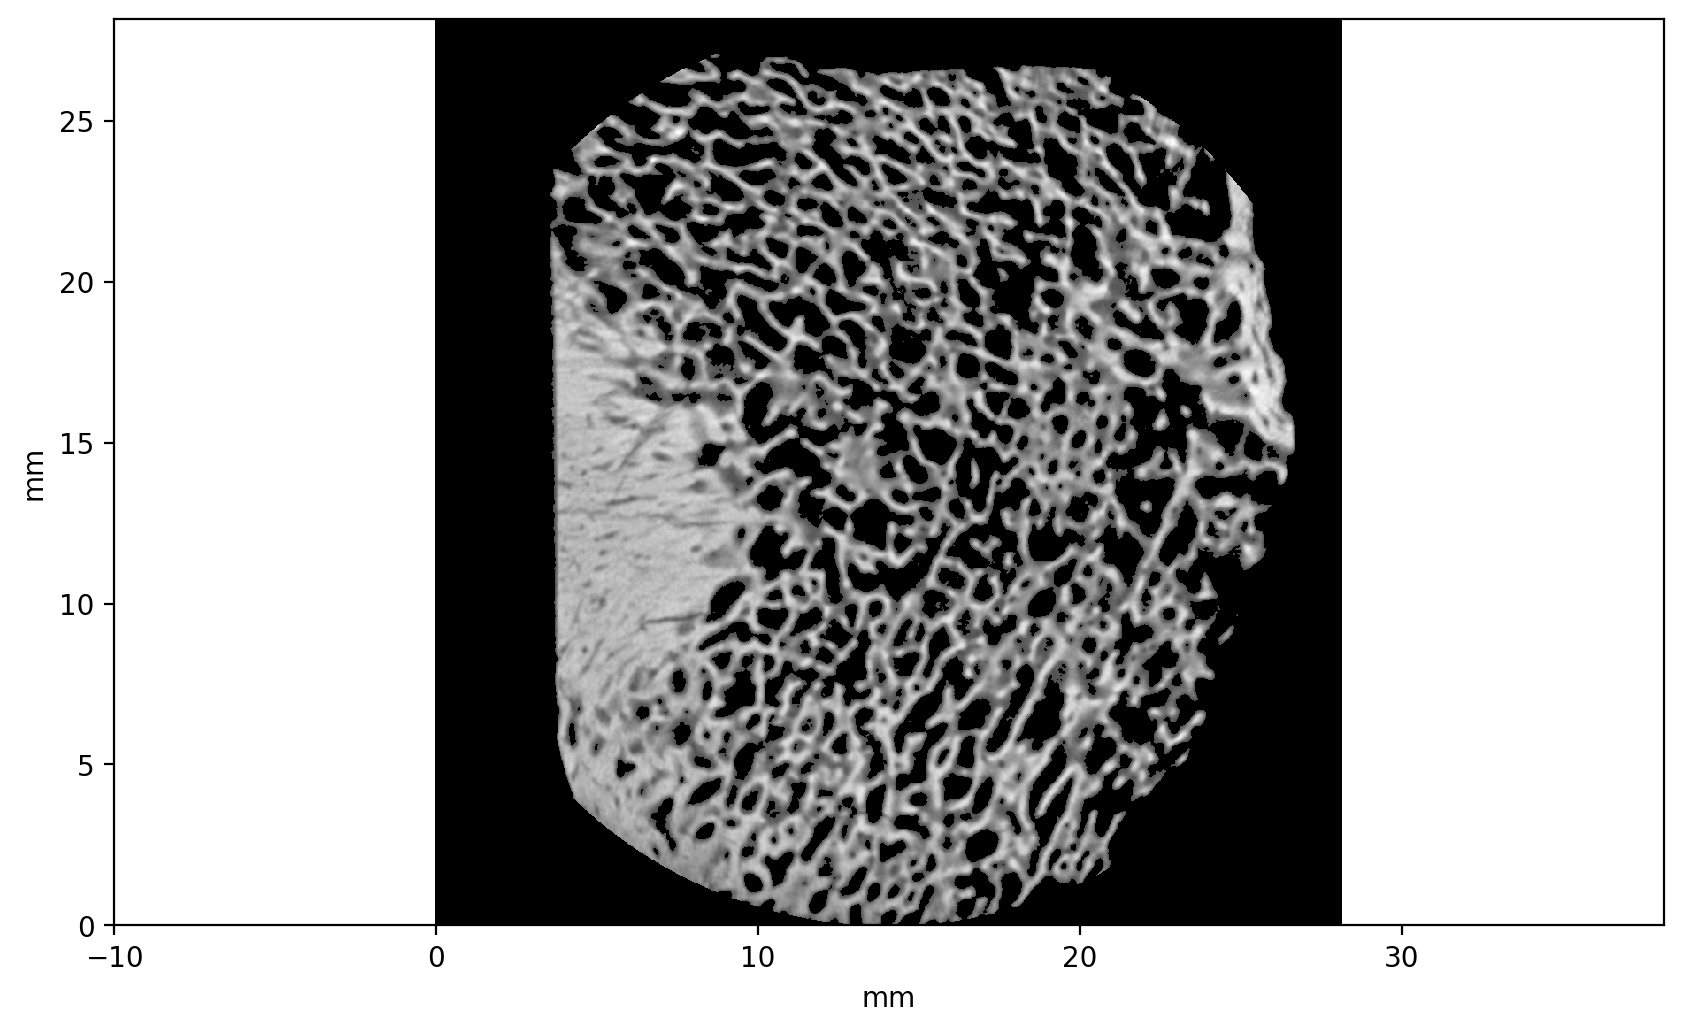

結果は以下のファイルに保存されます
200425_DICOMfile9_0.3Cort_3Skin_Ph5.csv


In [3]:
##### Data setup ######

#パラメータの入力
nPh = 10**5    #光子数
skin = 3       #皮膚厚 (0は皮膚なし)
cortical = 0.3 #緻密骨 0 もしくは 0.3 で計算してください。
w0 = 0.54       #レーザーのスポット半径
dicom = "DICOMfile9" #計算するデータのフォルダ名

#DICO 画像の読み込み
Tissue,resolution,ConstPixelDims,ConstPixelSpacing = dcm.readDicom(dicom) 
Tissue = dcm.reConstArray(Tissue,threshold = 9500)
dcm.displayGraph(Tissue,resolution)

#Tissueの定義
Tissue,cor,ski = defineTissue(Tissue,cortical,skin)

#結果保存用のファイル名の生成
fname = getFname(dicom,nPh,cor,ski)

print("結果は以下のファイルに保存されます")
print(fname)

TEM00を入力


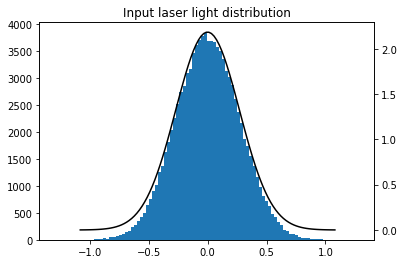

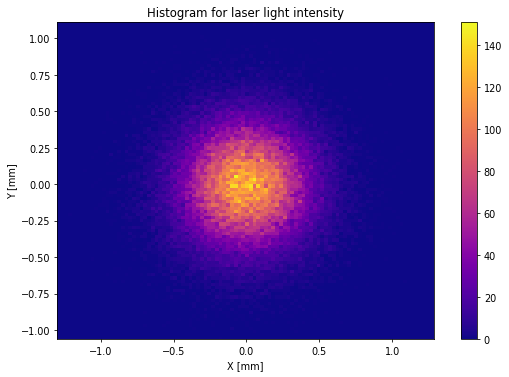

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:316: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: DeprecationWarning: elementwise comparison failed; this will rai

Progress: 0.112 [％]
Calculation time: 0 minutes 1 seconds.
Progress: 0.562 [％]
Calculation time: 0 minutes 2 seconds.
Progress: 1.555 [％]
Calculation time: 0 minutes 4 seconds.
Progress: 3.602 [％]
Calculation time: 0 minutes 7 seconds.
Progress: 7.412 [％]
Calculation time: 0 minutes 14 seconds.
Progress: 14.7 [％]
Calculation time: 0 minutes 26 seconds.
Progress: 26.176 [％]
Calculation time: 0 minutes 45 seconds.
Progress: 42.327 [％]
Calculation time: 1 minutes 19 seconds.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: RuntimeWarning: overflow encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:253: RuntimeWarning: invalid value encountered in multiply
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:243: RuntimeWarning: invalid value encountered in less_equal


Progress: 66.994 [％]
Calculation time: 2 minutes 4 seconds.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:253: RuntimeWarning: overflow encountered in add
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:253: RuntimeWarning: invalid value encountered in add


Progress: 88.966 [％]
Calculation time: 2 minutes 42 seconds.
Progress: 98.053 [％]
Calculation time: 3 minutes 0 seconds.
Progress: 98.977 [％]
Calculation time: 3 minutes 9 seconds.
Progress: 98.981 [％]
Calculation time: 3 minutes 20 seconds.
Progress: 98.981 [％]
Calculation time: 3 minutes 38 seconds.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: RuntimeWarning: invalid value encountered in multiply


Progress: 98.981 [％]
Calculation time: 4 minutes 12 seconds.
Progress: 98.981 [％]
Calculation time: 5 minutes 29 seconds.
Progress: 98.981 [％]
Calculation time: 7 minutes 53 seconds.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in reciprocal
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


Progress: 98.981 [％]
Calculation time: 12 minutes 50 seconds.


KeyboardInterrupt: 

In [4]:
#### シミュレーション #####

#モンテカルロの計算
v,p,add,w = MonteCalro(nPh,w0)

#結果の保存
os.chdir(workspace)
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result')
saveFile(v,p,add,w,fname =fname)
os.chdir(workspace)

In [5]:
#Tissueの定義
Tissue,cor,ski = defineTissue(Tissue,cortical,skin)

#結果保存用のファイル名の生成
fname = getFname(dicom,nPh,cor,ski)

print("結果は以下のファイルに保存されます")
print(fname)
#結果の保存
os.chdir(workspace)
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result')
saveFile(v,p,add,w,fname =fname)
os.chdir(workspace)

結果は以下のファイルに保存されます
191027_DICOMfile4_0.3Cort_3Skin_Ph7.csv
Calculation time: 13 minutes 51 seconds.
File name: 191027_DICOMfile4_0.3Cort_3Skin_Ph7.csv


In [ ]:
#####  ↓↓ Miura用 ↓↓ #####

C:\Users\HP ENVY SmartLab\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\HP ENVY SmartLab\Anaconda3\lib\site-packages\ipykernel_launcher.py:235: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\HP ENVY SmartLab\Anaconda3\lib\site-packages\ipykernel_launcher.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\HP ENVY SmartLab\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.
Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.
Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.
Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.
Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.
Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.
Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.
Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.

###### Result ######
Maximum step number: 349
Photon weight reduction late: 34.267 ％
Calculation time: 0 minutes 0 seconds.


C:\Users\HP ENVY SmartLab\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


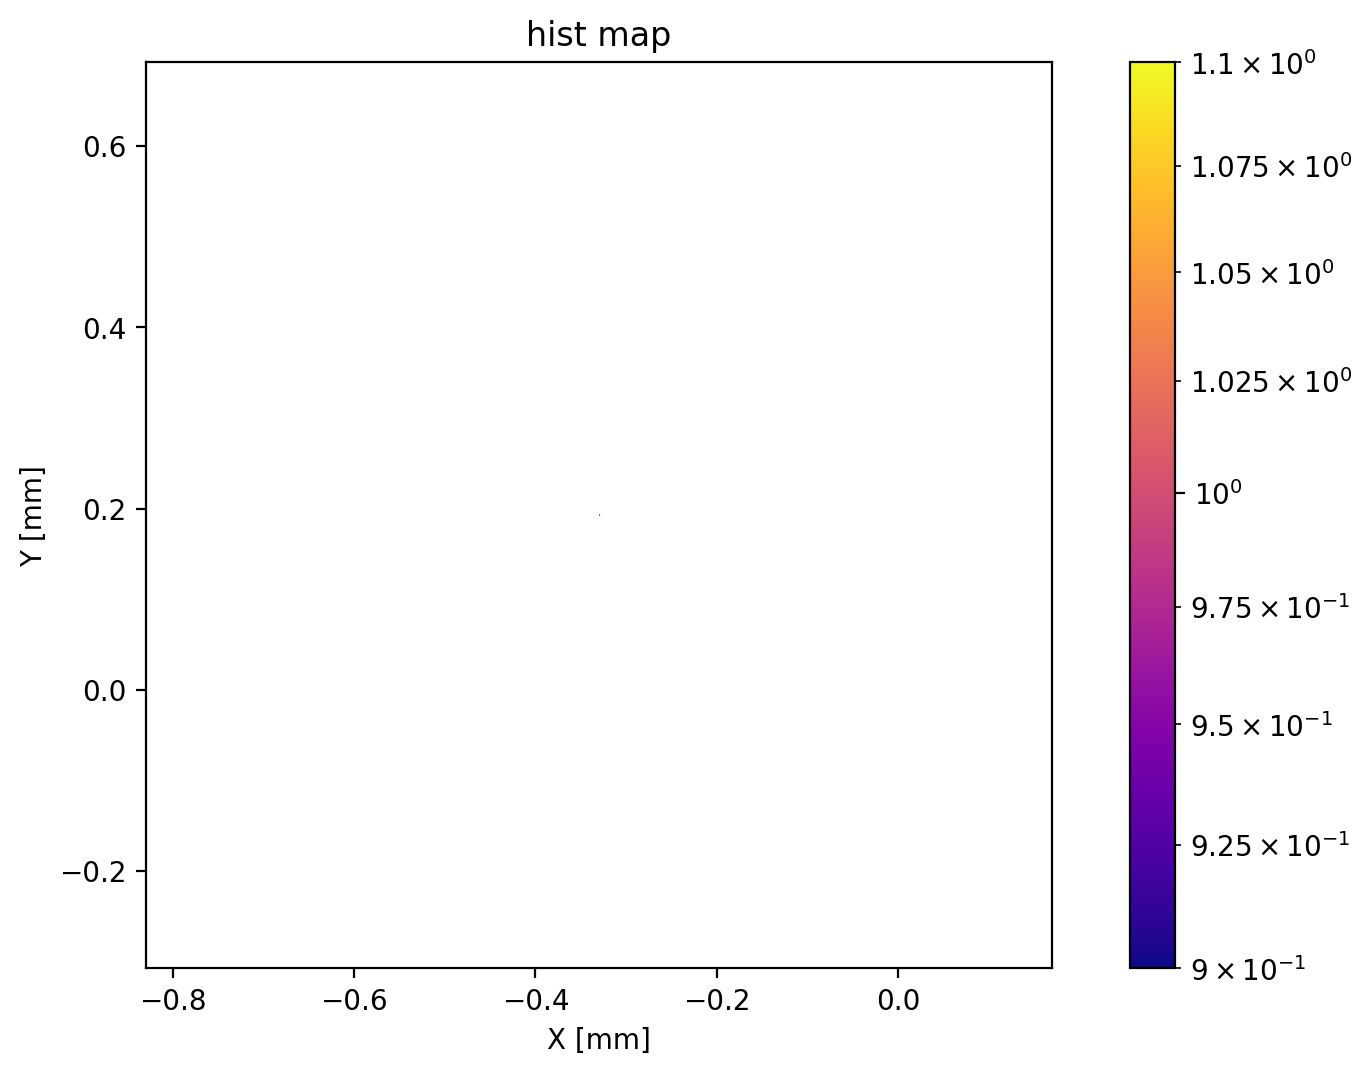

In [74]:
#### 確認用 ####
nPh = 2

f_bit = "float32"
start_ = time.time()

#初期値の設定
l = ConstPixelSpacing[0]
p = np.zeros((3,nPh)).astype(f_bit)
p[2] = -l/2
v = np.zeros((3,nPh)).astype(f_bit)
v[2] = 1
address =  np.full((3, nPh),int(ConstPixelDims[0]/2) ).astype("int16")
address[2] = 0
w = np.full(nPh,1-0.2).astype(f_bit)

#結果保存用の配列を定義
v_result = np.empty((3,1)).astype(f_bit)
p_result = np.empty((3,1)).astype(f_bit)
add_result = np.empty((3,1)).astype("int16")
w_result = np.empty(1).astype(f_bit)
count = 0
counter = 2
add_list = []
while(v != []):
    #print(count)
    p,v,address,w,result = updater(p,v,address,w,l,f_bit)
    add_list.append(address)
    if result[0][0].tolist() != []:
        v_result = np.concatenate([v_result, result[0]],axis = 1)
        p_result = np.concatenate([p_result, result[1]],axis = 1)
        add_result = np.concatenate([add_result, result[2]],axis = 1)
        w_result = np.concatenate([w_result, result[3]])
    count+=1
    if count%counter==0:
        counter*=2
        print("Progress: %s [％]"%round((1-w.size/nPh)*100,3))
        calTime(time.time(), start_)
print("")
print("###### Result ######")
print("Maximum step number: %s"%count)
print("Photon weight reduction late: %s ％"%round((1-np.sum(w_result)/nPh)*100,3))
calTime(time.time(), start_)
v_result = v_result[:,1:]
p_result = p_result[:,1:]
add_result = add_result[:,1:]
w_result = w_result[1:]

fig = plt.figure(figsize=(10,6),dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
y = (add_result[0]-(ConstPixelDims[0]/2))*l
x = (add_result[1]-(ConstPixelDims[0]/2))*l
H = ax.hist2d(x,y, bins=2**10,cmap="plasma",norm=matplotlib.colors.LogNorm())
ax.set_title('hist map')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
fig.colorbar(H[3],ax=ax)
plt.show()


In [75]:
add_list

[array([[512, 512],
        [512, 512],
        [  1,   1]], dtype=int16), array([[512, 512],
        [512, 511],
        [  2,   1]], dtype=int16), array([[512, 512],
        [512, 511],
        [  3,   2]], dtype=int16), array([[512, 512],
        [512, 511],
        [  4,   2]], dtype=int16), array([[512, 512],
        [512, 511],
        [  5,   2]], dtype=int16), array([[512, 512],
        [512, 511],
        [  5,   3]], dtype=int16), array([[512, 511],
        [512, 511],
        [  6,   3]], dtype=int16), array([[512, 511],
        [512, 511],
        [  7,   3]], dtype=int16), array([[512, 511],
        [512, 511],
        [  8,   4]], dtype=int16), array([[512, 511],
        [512, 510],
        [  8,   4]], dtype=int16), array([[512, 510],
        [512, 510],
        [  9,   4]], dtype=int16), array([[511, 510],
        [512, 510],
        [  9,   5]], dtype=int16), array([[511, 510],
        [512, 510],
        [ 10,   5]], dtype=int16), array([[511, 510],
        [512, 510]

In [76]:
len(add_list)

349

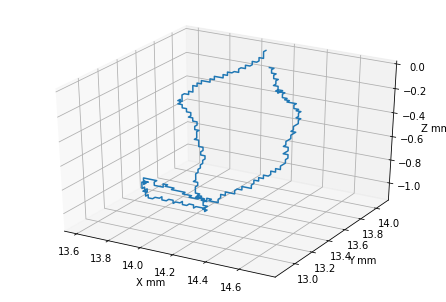

In [79]:
a = np.array(add_list[0:347])[:,:,1]*ConstPixelSpacing[0]
X = a.T[0]
Y = a.T[1]
Z = a.T[2]*-1

#3次元プロットするためのモジュール
from mpl_toolkits.mplot3d import Axes3D

#グラフの枠を作っていく
fig = plt.figure()
ax = Axes3D(fig)

#軸にラベルを付けたいときは書く
ax.set_xlabel("X mm")
ax.set_ylabel("Y mm")
ax.set_zlabel("Z mm")

ax.plot(X,Y,Z,"-")#,linestyle='None')
plt.show()

(3, 1)


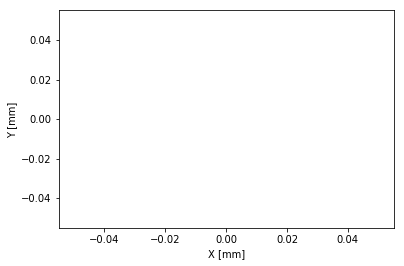

Calculation time: 0 minutes 0 seconds.


In [193]:
print(add.shape)
start_ = time.time()
#plt.axes().set_aspect('equal', 'datalim')
plt.plot((add[0,1:]-(ConstPixelDims[0]/2))*ConstPixelSpacing[0],
         (add[1,1:]-(ConstPixelDims[1]/2))*ConstPixelSpacing[1],".")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.show() 
calTime(time.time(), start_)

In [6]:
start_ = time.time()
add = add[:,1:]
fig = plt.figure(figsize=(10,6),dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
y = (add[0]-(ConstPixelDims[0]/2))*l
x = (add[1]-(ConstPixelDims[0]/2))*l
H = ax.hist2d(x,y, bins=2**10,cmap="plasma",norm=matplotlib.colors.LogNorm())
ax.set_title('hist map')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
#ax.set_ylim(-12,12)
#ax.set_xlim(-15,15)
fig.colorbar(H[3],ax=ax)
plt.show()
calTime(time.time(), start_)
#viridis
#inferno
#"YlOrRd"
#plasma

NameError: name 'add' is not defined

In [ ]:
import pandas as pa
start_ = time.time()
df = pa.DataFrame(add_result)
df.to_csv("add_result.csv")
df = pa.DataFrame(v_result)
df.to_csv("v_result.csv")
df = pa.DataFrame(p_result)
df.to_csv("p_result.csv")
df = pa.DataFrame(w_result)
df.to_csv("w_result.csv")
calTime(time.time(), start_)

In [163]:

#GPGPU
def vectorUpdateGpgpu(v,f="float32",g = 0.93):
    #それぞれの関数を変数に入れて文字数を少なくする
    add = cu.add
    mul = cu.multiply
    sub = cu.subtract
    sqr = cu.sqrt
    squ = cu.square
    rec = cu.reciprocal
    neg = cu.negative
    rdm = cu.random
    G1 = (1+g**2)/(2*g)
    G2 = np.sqrt(2*g)/(1+g)
    G3 = np.sqrt(8*g**3)/(1-g**2)
    
    v1_index = cu.where(cu.abs(v[2])<=0.99999)[0].tolist()
    def v1calc(v1):
        v1 = v[:,v1[2]<=0.99999]
        v1size = v1[0].size
        cosTh = G1-rec(squ(G2+G3*rdm.rand(v1size).astype(f)))
        sinTh = sqr(1-squ(cosTh))
        #φを求める
        Fi = 2*np.pi*rdm.rand(v1size).astype(f)
        #v1ベクトルの更新
        C = cu.zeros(v1.size).reshape(3, v1size).astype('f') 
        C[0] = cu.negative(v1[1])
        C[1] = v1[0]
        B = mul(rec(sqr(1-squ(v1[2]))),v1)
        B[2] = neg(rec(B[2]))
        B = mul(mul(sinTh,cu.cos(Fi)),mul(v1[2],B))
        return add(mul(v1,cosTh),
                   sub(B,mul(mul(rec(sqr(1-squ(v1[2]))),
                                 sinTh),mul(cu.sin(Fi),C))))

    v2_index = cu.where(cu.abs(v[2])>0.99999)[0].tolist()
    v2 = cu.sign(v[2][cu.abs(v[2])>0.99999])
    def v2calc(v2):
        v2size = len(v2_index)
        cosTh = G1-rec(squ(G2+G3*rdm.rand(v2size).astype(f)))
        sinTh = sqr(1-squ(cosTh))
        Fi = 2*np.pi*rdm.rand(v2size).astype(f)
        return (mul(sinTh,cu.cos(Fi)),
                mul(sinTh,cu.sin(Fi)),
                mul(v2,cosTh))

    ##v1,v2の結合
    v[:,v1_index]=v1calc(v)
    v[:,v2_index]=v2calc(v2)
    
    return v



In [19]:

def normalize(v, axis=0):
    l2 = cu.linalg.norm(v, ord = 2, axis=axis, keepdims=True)
    l2[l2==0] = 1
    return cu.multiply(v,cu.reciprocal(l2))

v = normalize(cu.random.rand(3,10000000).astype("float32"))
v[2][5] = 1

s = time.time()
v = vectorUpdateGpgpu(v,f = "float32",g = 0.93)
tcupy = time.time()-s
print(tcupy)

0.8569486141204834


In [22]:
def normalize(v, axis=0):
    l2 = np.linalg.norm(v, ord = 2, axis=axis, keepdims=True)
    l2[l2==0] = 1
    return np.multiply(v,np.reciprocal(l2))
v = normalize(np.random.rand(3,10000000).astype("float32"))

s = time.time()
v = vectorUpdate(v,f = "float32",g = 0.63)
tnumpy = time.time()-s
print(tnumpy)

2.3942699432373047


In [23]:
tnumpy/tcupy

2.7939480895183295

In [2]:
import time
s = time.time()
g = 0.93
G1 = (1+g**2)/(2*g)
G2 = np.sqrt(2*g)/(1+g)
G3 = np.sqrt(8*g**3)/(1-g**2)
sinTh = np.sqrt(1-np.square(G1-np.reciprocal(np.square(G2+G3*np.random.rand(10**8).astype("float32")))))
t = time.time()-s
print(t)

1.6916313171386719


In [23]:
import cupy as cu
import time
import numpy as np
def sinThc():
    s = cu.sqrt(1-cu.square(G1-cu.reciprocal(cu.square(G2+G3*cu.random.rand(10**8).astype("float32")))))
    return s
s = time.time()
g = 0.93
G1 = (1+g**2)/(2*g)
G2 = np.sqrt(2*g)/(1+g)
G3 = np.sqrt(8*g**3)/(1-g**2)
a = sinThc()
t = time.time()-s
print(t)
a.shape

0.000997304916381836


(100000000,)

In [24]:
import math
g = 0.93
def photonScattering(): #光子の散乱
    #r = random.random()
    shita = np.arccos((1/(2*g))*(1+g**2-((1-(g)**2)/(1-g+2*g*np.random.rand()))**2))
    fai = 2*np.pi*np.random.rand()
    return shita, fai

def vectorConv(ux,uy,uz): #ベクトルの変更
    s,f = photonScattering()
    nux = np.sin(s)*(ux*uz*np.cos(f) - uy*np.sin(f))/(np.sqrt(1-uz**2)) + ux*np.cos(s)
    nuy = np.sin(s)*(uy*uz*np.cos(f) + ux*np.sin(f))/(np.sqrt(1-uz**2)) + uy*np.cos(s)
    nuz = -np.sin(s)*np.cos(f)*np.sqrt(1-uz**2) + uz*np.cos(s)
    return nux, nuy, nuz

def exVectorConv(ux,uy,uz): #|uz| > 0.99999の時に発動
    s,f = photonScattering()
    nux = math.sin(s)*math.cos(f)
    nuy = math.sin(s)*math.sin(f)
    nuz = uz*math.cos(s)/abs(uz)
    return nux, nuy, nuz

In [26]:
import time
s = time.time()
for i in range(1000000):
    v = np.random.rand(3)
    a,b,c = vectorConv(v[0],v[1],v[2])
t = time.time()-s
print(t)

16.145934581756592


In [27]:
t/tnumpy

6.743573182865751

In [28]:
t/tcupy

18.841193410794805